In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prodzar/stocks-historical-price-data")


C:\Users\supre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import pandas as pd
import os

# Path to your directory containing the CSV files
current_dir = os.getcwd()
download_path = os.path.join(current_dir, '..', 'new_dataset', 'historical_data')
download_path = os.path.normpath(download_path)
merged_data = pd.DataFrame()

# Loop through each file in the directory
for file in os.listdir(download_path):
    if file.endswith(".csv"):
        # Extract company name from the filename (without .csv extension)
        company_name = file.replace(".csv", "")
        
        # Load CSV into a DataFrame
        file_path = os.path.join(download_path, file)
        df = pd.read_csv(file_path)
        
        # Add a new column for the company name
        df["Company"] = company_name
        
        # Append to the merged DataFrame
        merged_data = pd.concat([merged_data, df], ignore_index=True)

# Save the merged DataFrame to a new CSV file
output_path = os.path.join(current_dir, '..', 'merged_stocks_data.csv')
output_path = os.path.normpath(output_path)
merged_data.to_csv(output_path, index=False)

print("Data merged successfully into merged_stocks_data.csv.")


Data merged successfully into merged_stocks_data.csv.


In [3]:
merged_data.tail()

,Date,Open,High,Low,Close,Adjusted Close,Volume,Dividend Amount,Split Coefficient,Company
15055,2024-11-21,121.08,122.5547,120.270,121.93,121.93,14675422,0.0,1.0,XOM
15056,2024-11-22,121.82,123.2100,121.640,121.79,121.79,13323431,0.0,1.0,XOM
15057,2024-11-25,121.43,121.8800,119.610,119.97,119.97,26580295,0.0,1.0,XOM
15058,2024-11-26,119.53,119.6800,117.845,117.97,117.97,14827327,0.0,1.0,XOM
15059,2024-11-27,118.09,118.7300,117.430,117.66,117.66,11079122,0.0,1.0,XOM


In [4]:
import numpy as np
import pandas as pd
import random
import ta
from collections import deque
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



Episode 1, Total Reward: 223.16, Balance: 10223.16, Shares Held: 0, Actions: {'Buy_1': 150, 'Hold': 143, 'Sell_1': 138, 'Buy_5': 136, 'Sell_5': 136}
Episode 2, Total Reward: 45.99, Balance: 10045.99, Shares Held: 0, Actions: {'Sell_5': 157, 'Buy_5': 146, 'Hold': 139, 'Buy_1': 132, 'Sell_1': 129}
Episode 3, Total Reward: 149.83, Balance: 10149.83, Shares Held: 0, Actions: {'Buy_1': 154, 'Hold': 147, 'Buy_5': 142, 'Sell_1': 131, 'Sell_5': 129}
Episode 4, Total Reward: 150.86, Balance: 10150.86, Shares Held: 0, Actions: {'Hold': 155, 'Buy_5': 149, 'Sell_5': 143, 'Sell_1': 129, 'Buy_1': 127}
Episode 5, Total Reward: 104.18, Balance: 10104.18, Shares Held: 0, Actions: {'Sell_1': 149, 'Sell_5': 148, 'Buy_1': 143, 'Hold': 143, 'Buy_5': 120}
Episode 6, Total Reward: 58.33, Balance: 10058.33, Shares Held: 0, Actions: {'Sell_5': 156, 'Buy_1': 150, 'Hold': 145, 'Sell_1': 127, 'Buy_5': 125}
Episode 7, Total Reward: 288.58, Balance: 10288.58, Shares Held: 0, Actions: {'Buy_5': 161, 'Buy_1': 151, 'S

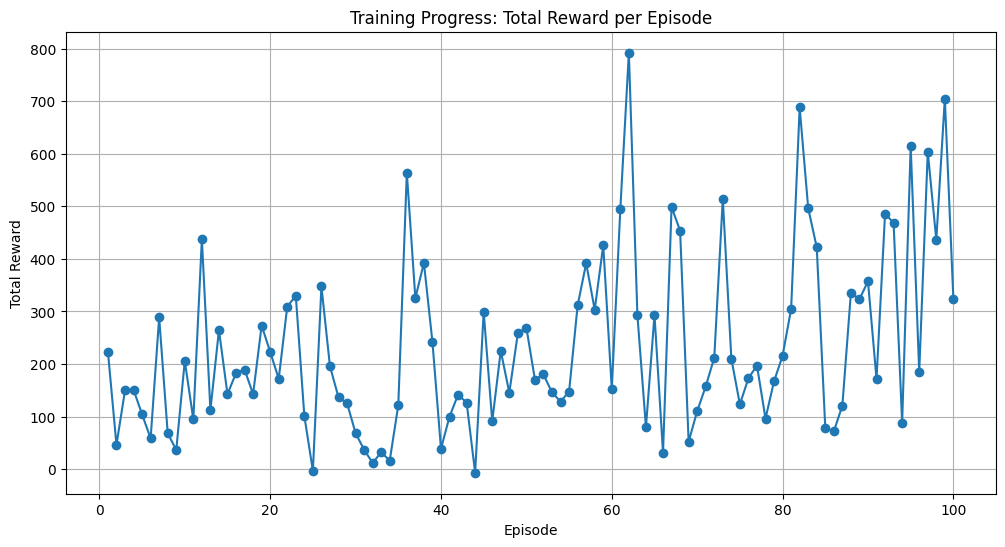

Q-table saved successfully.
Test Total Reward: 776.64, Final Balance: 10776.64, Shares Held: 0


In [5]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Function to compute RSI using the ta library
def compute_rsi(series, window=14):
    return ta.momentum.RSIIndicator(series, window=window).rsi()

# Define the base directory (adjust based on your project structure)
base_dir = Path.cwd().parent  # Assuming the notebook is inside 'Reinforcement learning' folder

# Define the relative path to the merged_stocks_data.csv
data_path = base_dir / 'merged_stocks_data.csv'

# Check if the file exists
if not data_path.exists():
    raise FileNotFoundError(f"The file {data_path} does not exist.")

# Load your merged data using the relative path
data = pd.read_csv(data_path)

# Filter data by company name (e.g., for a specific company)
company_data = data[data['Company'] == 'AAPL'].reset_index(drop=True)

# Feature Engineering: Adding Moving Averages and RSI as technical indicators
company_data['MA10'] = company_data['Close'].rolling(window=10).mean()
company_data['MA50'] = company_data['Close'].rolling(window=50).mean()
company_data['RSI'] = compute_rsi(company_data['Close'], window=14)  # Using ta library

# Discretize RSI into categories
def discretize_rsi(rsi_value):
    if rsi_value < 30:
        return 'Oversold'
    elif 30 <= rsi_value < 70:
        return 'Neutral'
    else:
        return 'Overbought'

company_data['RSI_Category'] = company_data['RSI'].apply(discretize_rsi)

# Drop rows with NaN values resulting from moving averages and RSI, then reset the index
company_data = company_data.dropna().reset_index(drop=True)

# Normalize the features (excluding categorical RSI)
scaler = StandardScaler()
company_data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA10', 'MA50', 'RSI']] = scaler.fit_transform(
    company_data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA10', 'MA50', 'RSI']]
)

# Q-learning parameters
actions = ["Buy_1", "Buy_5", "Sell_1", "Sell_5", "Hold"]  # Actions the agent can take
alpha = 0.05  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995  # Decay rate for epsilon
q_table = {}  # Q-table for state-action pairs

# Initialize environment parameters
initial_balance = 10000  # Increased initial balance for multiple shares
balance = initial_balance  # Current balance
shares_held = 0  # Initial shares held
transaction_cost_percentage = 0.001  # 0.1% transaction cost per trade

# Function to get state
def get_state(data, t):
    # Exclude categorical RSI for state representation
    return tuple(data.iloc[t][["Close", "MA10", "MA50", "RSI"]])

# Reward function: Change in portfolio value
def get_reward(action, current_price, shares_held, balance, previous_portfolio_value):
    portfolio_value = balance + shares_held * current_price
    # Implement actions
    if action == "Buy_1" and balance >= (current_price * (1 + transaction_cost_percentage)):
        cost = current_price * (1 + transaction_cost_percentage)
        balance -= cost
        shares_held += 1
    elif action == "Buy_5" and balance >= (current_price * 5 * (1 + transaction_cost_percentage)):
        cost = current_price * 5 * (1 + transaction_cost_percentage)
        balance -= cost
        shares_held += 5
    elif action == "Sell_1" and shares_held >= 1:
        revenue = current_price * (1 - transaction_cost_percentage)
        balance += revenue
        shares_held -= 1
    elif action == "Sell_5" and shares_held >= 5:
        revenue = current_price * 5 * (1 - transaction_cost_percentage)
        balance += revenue
        shares_held -= 5
    # Hold does nothing
    
    new_portfolio_value = balance + shares_held * current_price
    reward = new_portfolio_value - previous_portfolio_value
    return reward, balance, shares_held

# Initialize a list to store rewards for visualization
episode_rewards = []

# Q-learning algorithm
for episode in range(1, 101):  # Training for 100 episodes
    balance = initial_balance
    shares_held = 0
    total_reward = 0
    actions_taken = []
    
    for t in range(len(company_data) - 1):
        state = get_state(company_data, t)
        
        # Initialize Q-values for unseen states
        if state not in q_table:
            q_table[state] = [0] * len(actions)
        
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action_index = random.randint(0, len(actions) - 1)  # Explore
        else:
            action_index = np.argmax(q_table[state])  # Exploit
        
        action = actions[action_index]
        current_price = company_data.loc[t, "Close"]
        previous_portfolio_value = balance + shares_held * current_price
        reward, balance, shares_held = get_reward(action, current_price, shares_held, balance, previous_portfolio_value)
        
        actions_taken.append(action)
        total_reward += reward
        
        # Next state
        next_state = get_state(company_data, t + 1)
        
        # Initialize Q-values for unseen next states
        if next_state not in q_table:
            q_table[next_state] = [0] * len(actions)
        
        # Q-learning update using Bellman equation
        old_q_value = q_table[state][action_index]
        next_max_q = max(q_table[next_state])
        q_table[state][action_index] = old_q_value + alpha * (reward + gamma * next_max_q - old_q_value)
    
    # Handle end-of-episode: sell any remaining shares
    final_price = company_data.loc[len(company_data) - 1, "Close"]
    if shares_held > 0:
        revenue = final_price * (1 - transaction_cost_percentage) * shares_held
        balance += revenue
        total_reward += revenue
        shares_held = 0
    
    # Calculate final portfolio value
    final_portfolio_value = balance + shares_held * final_price
    episode_reward = final_portfolio_value - initial_balance
    episode_rewards.append(episode_reward)
    
    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    
    # Logging
    action_counts = pd.Series(actions_taken).value_counts().to_dict()
    print(f"Episode {episode}, Total Reward: {episode_reward:.2f}, Balance: {balance:.2f}, Shares Held: {shares_held}, Actions: {action_counts}")

print("Training complete.")

# Plot Training Rewards
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress: Total Reward per Episode')
plt.grid(True)
plt.show()

# Save the Q-table for future use
import pickle
with open(base_dir / 'q_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)
print("Q-table saved successfully.")

# Test phase (using the trained Q-table)
balance = initial_balance
shares_held = 0
total_reward = 0

for t in range(len(company_data) - 1):
    state = get_state(company_data, t)
    if state not in q_table:
        q_table[state] = [0] * len(actions)
    
    action_index = np.argmax(q_table[state])  # Always exploit
    action = actions[action_index]
    current_price = company_data.loc[t, "Close"]
    previous_portfolio_value = balance + shares_held * current_price
    reward, balance, shares_held = get_reward(action, current_price, shares_held, balance, previous_portfolio_value)
    total_reward += reward

# Sell any remaining shares at the end of the test
final_price = company_data.loc[len(company_data) - 1, "Close"]
if shares_held > 0:
    revenue = final_price * (1 - transaction_cost_percentage) * shares_held
    balance += revenue
    total_reward += revenue
    shares_held = 0

# Calculate final portfolio value
final_portfolio_value = balance + shares_held * final_price
test_reward = final_portfolio_value - initial_balance

print(f"Test Total Reward: {test_reward:.2f}, Final Balance: {balance:.2f}, Shares Held: {shares_held}")

State and Q-Table: For each day in the test data, the agent retrieves the current state and checks for that state in the Q-table.

Exploitation (No Exploration): For each state in the test data, the agent selects the action with the highest Q-value.

Action Execution:
"Buy": Deduct the price of one stock from the balance and increase the shares_held.
"Sell": Add the value of all held shares to the balance and set shares_held to zero.

Portfolio Value Calculation: Tracks the total portfolio value (balance + value of held shares) to see the agent’s progress.

End of Testing: Prints the final portfolio value and total profit at the end of the test period